# Changepoint Detection Example

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from kats.detectors.bocpd import BOCPDModelType
from scalecast.Forecaster import Forecaster
from scalecast.ChangepointDetector import ChangepointDetector

In [2]:
sns.set(rc={'figure.figsize':(12,8)})

In [3]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start='1959-01-01',
    end='2022-05-01',
).reset_index()

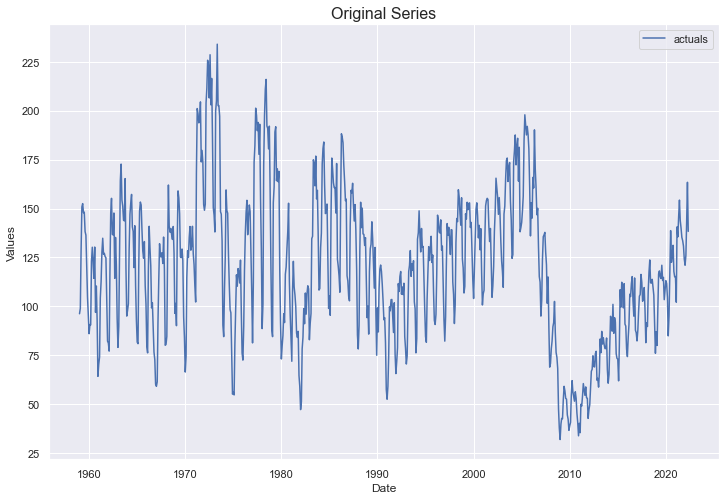

In [4]:
f = Forecaster(
    y=df['HOUSTNSA'],
    current_dates=df['DATE'],
)

f.plot()
plt.title('Original Series',size=16)
plt.show()

f.generate_future_dates(18)
f.set_test_length(18)
f.set_validation_metric('mae')

## CUSUM Detection

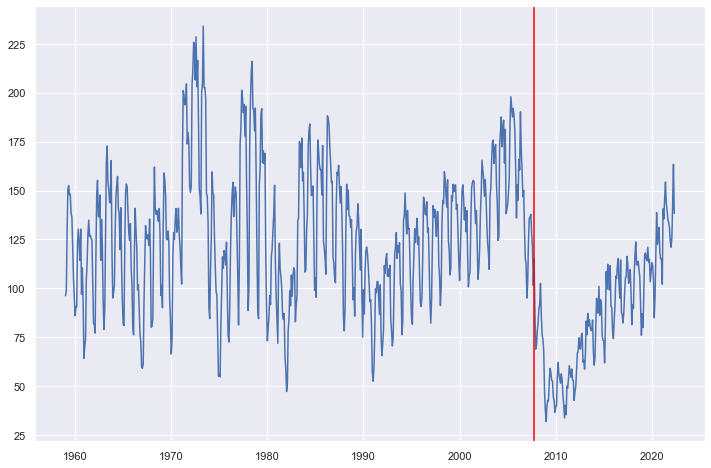

In [5]:
detector = ChangepointDetector(f)
detector.DetectCPCUSUM()
detector.plot()
plt.show()

In [6]:
detector.changepoints[0].start_time

Timestamp('2007-10-01 00:00:00')

## BOCPD Detector

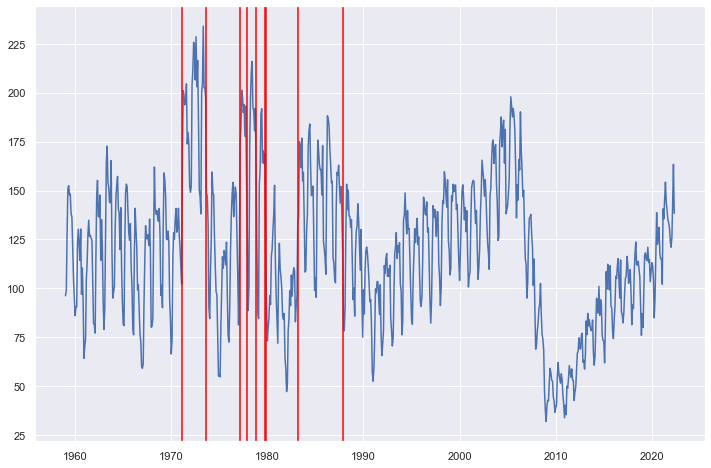

In [7]:
detector.DetectCPBOCPD()
detector.plot()
plt.show()

## CUSUM_sliding Detection

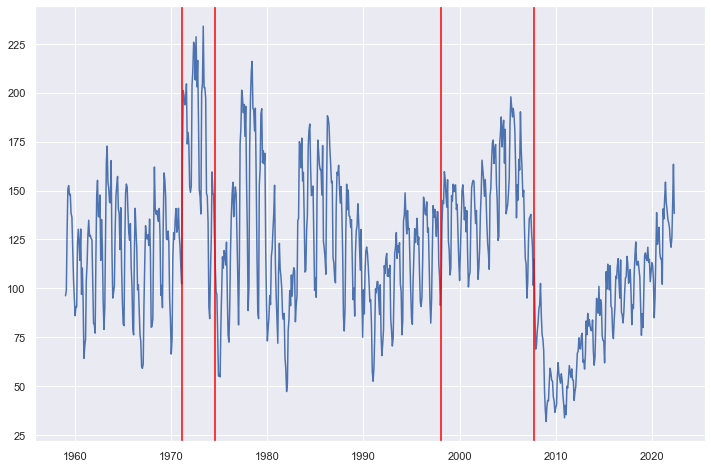

In [8]:
detector.DetectCPCUSUM_sliding(36,18,36)
detector.plot()
plt.show()

## Use Changepoints as Predictors

In [9]:
f = detector.WriteCPtoXvars(f)
f

CUSUMChangePoint(start_time: 1971-02-01 00:00:00, end_time: 1971-02-01 00:00:00, confidence: 0.9999999999958666, direction: increase, index: 37, delta: 66.22401315789477, regression_detected: True, stable_changepoint: True, mu0: 121.59473684210525, mu1: 187.81875000000002, llr: 52.42386898361005, llr_int: 14.838471004257777, p_value: 4.133360320679458e-12, p_value_int: 0.0005996073688936399)
CUSUMChangePoint(start_time: 1974-08-01 00:00:00, end_time: 1974-08-01 00:00:00, confidence: 0.9999998732701793, direction: decrease, index: 43, delta: -85.64090909090912, regression_detected: True, stable_changepoint: True, mu0: 169.69090909090912, mu1: 84.05, llr: 31.762416823962155, llr_int: 11.191455660214167, p_value: 1.267298207485723e-07, p_value_int: 0.003713695412288387)
CUSUMChangePoint(start_time: 1998-02-01 00:00:00, end_time: 1998-02-01 00:00:00, confidence: 0.9984782642556288, direction: increase, index: 37, delta: 21.409868421052636, regression_detected: True, stable_changepoint: Tru

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2022-05-01T00:00:00.000000000
    Freq=MS
    N_actuals=761
    ForecastLength=18
    Xvars=['cp1', 'cp2', 'cp3', 'cp4']
    Differenced=0
    TestLength=18
    ValidationLength=1
    ValidationMetric=mae
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
)

In [10]:
f.set_estimator('arima')
arima_grid = {
    'order':[
        (i,1,k) for i in range(6) for k in range(6)
    ],
    'seasonal_order':[
        (i,j,k,12) for i in range(3) for j in range(3) for k in range(3)
    ],
    'Xvars':[
        None,
        'all'
    ],
}
f.ingest_grid(arima_grid)
f.limit_grid_size(25,random_seed=20) # randomized grid search
f.cross_validate(k=10)
f.auto_forecast()

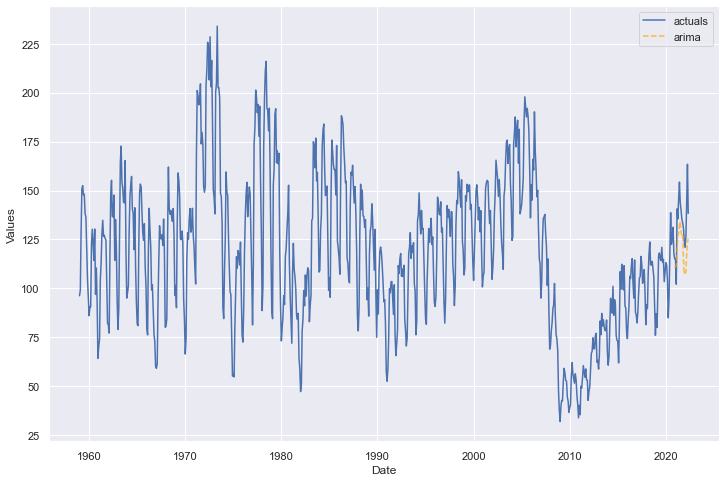

In [11]:
f.plot_test_set()
plt.show()

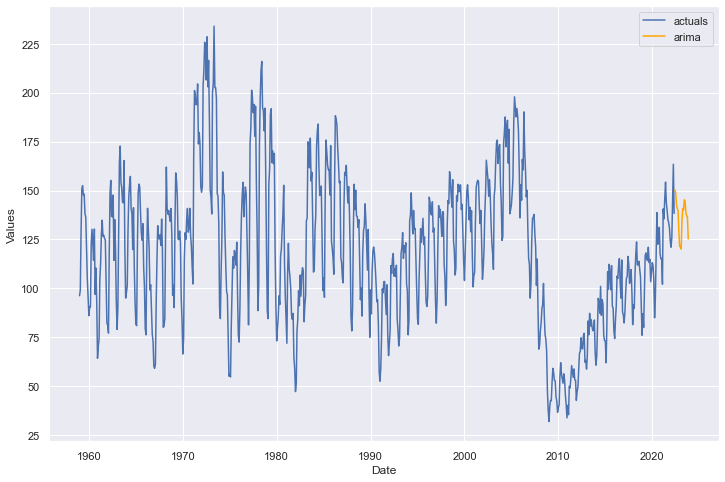

In [12]:
f.plot()
plt.show()

In [13]:
validation_grid = f.export_validation_grid('arima')
validation_grid.head()

,order,seasonal_order,Xvars,validation_length,validation_metric,metric_value,fold,rolling,train_length
0,"(2, 1, 4)","(1, 0, 1, 12)",all,67,mae,11.373854,0,False,676
1,"(5, 1, 4)","(2, 2, 2, 12)",None,67,mae,18.820618,0,False,676
2,"(1, 1, 3)","(1, 0, 2, 12)",all,67,mae,23.458804,0,False,676
3,"(4, 1, 3)","(0, 0, 1, 12)",all,67,mae,7.972048,0,False,676
4,"(2, 1, 4)","(1, 1, 0, 12)",all,67,mae,10.699340,0,False,676


In [14]:
pd.pivot_table(
    validation_grid,
    index='Xvars',
    columns='fold',
    values='metric_value',
    aggfunc='mean',
    margins=True,
    margins_name='grand mean',
)

fold,0,1,2,3,4,5,6,7,8,9,grand mean
Xvars,,,,,,,,,,,
None,1.293062e+07,60.310177,68.375507,25.313104,24.925213,34.585678,133.079503,53.100993,42.418266,57.056498,1.293112e+06
all,1.300975e+01,37.835609,62.340351,16.455274,19.284997,51.068857,117.895320,95.539182,67.079219,24.909113,4.983868e+01
grand mean,6.206704e+06,48.623402,65.237226,20.707032,21.992301,43.156931,125.183728,73.397518,55.241962,40.339858,6.257250e+05


In [15]:
f.best_params

{'order': (2, 1, 4), 'seasonal_order': (1, 0, 1, 12), 'Xvars': 'all'}

## Find SHAP Scores

In [16]:
f.add_ar_terms(6)
f.add_AR_terms((3,12))
f.add_seasonal_regressors('month',raw=False,sincos=True)
f.diff()

In [17]:
lightgbm_grid = {
    'n_estimators':[100,150,200,250],
    'boosting_type':['gbdt','dart','goss'],
    'max_depth':[1,2,3],
    'learning_rate':[0.001,0.01,0.1],
    'reg_alpha':np.linspace(0,1,5),
    'reg_lambda':np.linspace(0,1,5),
    'num_leaves':np.arange(5,50,5),
}
f.set_estimator('lightgbm')
f.ingest_grid(lightgbm_grid)
f.limit_grid_size(25,random_seed=20)
f.cross_validate(k=10)
f.auto_forecast()
f.save_feature_importance('shap')

In [18]:
f.best_params

{'n_estimators': 100,
 'boosting_type': 'dart',
 'max_depth': 3,
 'learning_rate': 0.1,
 'reg_alpha': 0.75,
 'reg_lambda': 0.5,
 'num_leaves': 25}

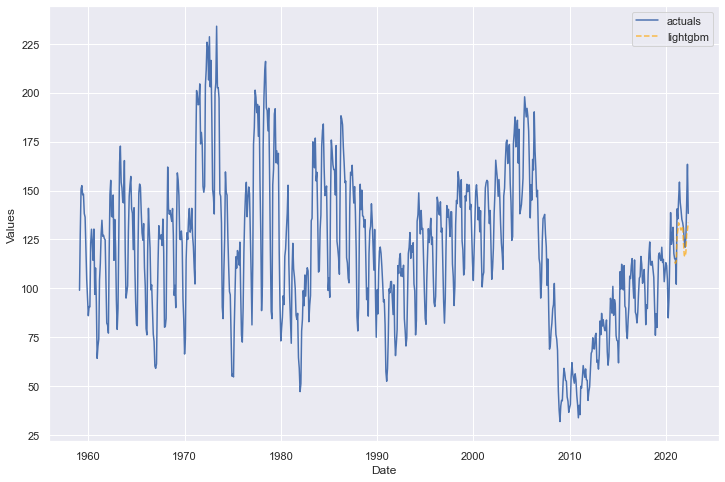

In [19]:
f.plot_test_set(models='lightgbm',level=True)
plt.show()

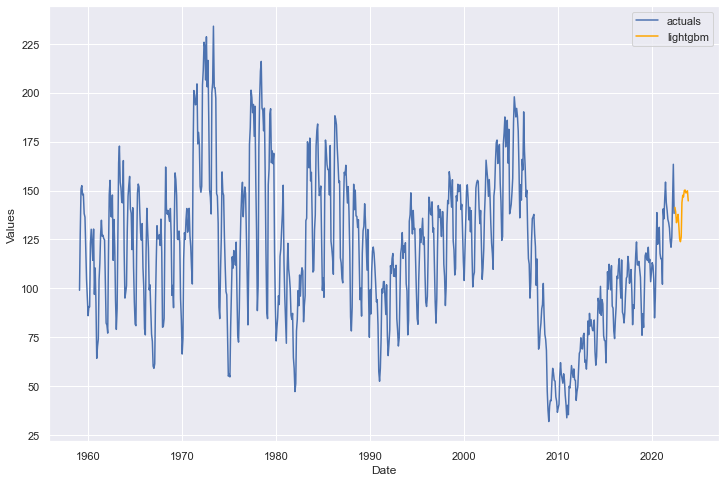

In [20]:
f.plot(models='lightgbm',level=True)
plt.show()

In [21]:
f.export_feature_importance('lightgbm')

,weight,std
feature,,
monthsin,3.462127,2.652651
monthcos,2.746438,1.620416
AR12,1.765067,2.188548
AR1,1.688347,0.994764
AR36,1.408556,1.507074
AR4,1.062094,0.965066
AR24,0.942087,0.999861
AR5,0.577493,0.533894
AR6,0.406668,0.447444
